In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
from dateutil.parser import parse
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 15)
import datetime
from dateutil.parser import parse
import math

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

### Research Context and Goal
The goal of the modelling at hand is to predict toxicity test values for the toxin type DSP in seashell based on the abundance of micro-algae in combination with available environmental data. Marine biologists are also interested to understand which species of micro-algae affects the accumulation of toxins in the seashells. 

The monitoring of abundance of micro-algae is carried out by the National Institute of Biology, Marine Biological Station Piran. The toxicity tests are performed by the National Veterinary Institute, Faculty of Veterinary Medicine (UL), which depending on the results of these tests administers bans on sales of shellfish. 

# Data preprocessing

## Micro-algae dataset

In [3]:
# Create micro-algae dataframe (empty cells -> NaN)
df_alg = pd.read_csv("data/Algae_Podatki_1994_onwards_24062021_Martin_1_0.csv", na_values = ["NA", "?"], sep=";")

# Keep only columns: PSP,  DSP,  Dinophysis species of special interest,  DSP_like,  ASP
df_alg = df_alg[["date", "sampling station", "sampling depth", "sampling method","PSP", "DSP", 
                 "DSP_like", "ASP", "Dinophysis caudata", "Dinophysis fortii", "Phalacroma rotundatum", 
                 "Dinophysis sacculus", "Dinophysis tripos"]]
#replace , with .
df_alg.replace(",", ".", regex=True, inplace=True)

# change str numbers to floats
df_alg.loc[:,"PSP":"Dinophysis tripos"] = df_alg.loc[:,"PSP":"Dinophysis tripos"].astype(float)

# create timestamp (Option to use parameter dayfirst=True, but seems unreliable)
df_alg["date"] = pd.to_datetime(df_alg["date"])

# sort by date attribute
df_alg = df_alg.sort_values('date')

# change str numbers to floats
df_alg.loc[:,"PSP":"Dinophysis tripos"] = df_alg.loc[:,"PSP":"Dinophysis tripos"].astype(float)

df_alg

,date,sampling station,sampling depth,sampling method,PSP,DSP,DSP_like,ASP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos
0,1994-05-17,35,0,Niskin,1206.0,68.0,NaN,NaN,27.0,0.0,21.0,0.0,0.0
1,1994-05-17,35,12,Niskin,31.0,16.0,NaN,NaN,13.0,0.0,3.0,0.0,0.0
2,1994-05-17,35,5,Niskin,0.0,41.0,NaN,NaN,38.0,0.0,3.0,0.0,0.0
3,1994-05-17,24,0,Niskin,4188.0,17.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0
4,1994-05-17,24,12,Niskin,222.0,2.0,NaN,NaN,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,2020-11-27,24,integrated,hose sampler,10.0,10.0,0.0,13000.0,0.0,0.0,0.0,0.0,0.0
1579,2020-11-27,0DB2,integrated,hose sampler,10.0,10.0,0.0,5000.0,0.0,0.0,10.0,0.0,0.0
1581,2020-12-15,35,integrated,hose sampler,0.0,20.0,0.0,1800.0,0.0,0.0,0.0,0.0,0.0
1580,2020-12-15,24,integrated,hose sampler,10.0,20.0,0.0,1200.0,0.0,0.0,10.0,0.0,0.0


In [4]:
# Rescale values of samples with sampling method type "integrated phytoplankton net" by factor
phyto_net_factor = 100
idxs_net = df_alg[df_alg["sampling method"] == "phytoplankton net"].index
df_alg.loc[idxs_net, "PSP":"Dinophysis tripos"] = df_alg.loc[idxs_net, "PSP":"Dinophysis tripos"]*phyto_net_factor

In [5]:
# Resolve multiple samples from the same day and location with different sampling depth by keeping only 
# those with the highest abundace value of priority microalgae type (DSP).
df_alg_depth = df_alg.copy()
df_alg_depth["org_index"] = df_alg_depth.index
df_max_DSP = df_alg_depth.groupby(["date", "sampling station"], 
                                  as_index=False).agg({"DSP": lambda x: np.argmax(x), "org_index": lambda x: tuple(x)})
# df_max_DSP

# Use max value index of tuple consisting of original indexes to find the maxid (for DSP) of original dataset
maxid_list = []
for df_idx, group_idxs in df_max_DSP.org_index.iteritems():
    tuple_idx = df_max_DSP.loc[df_idx, "DSP"]
    maxid_list.append(group_idxs[tuple_idx]) 

df_alg = df_alg.iloc[maxid_list]

In [6]:
# Count of missing values
df_alg.isnull().sum()

date                       0
sampling station           0
sampling depth             0
sampling method            0
PSP                        5
DSP                        1
DSP_like                  60
ASP                      344
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
dtype: int64

## Toxins dataset

In [7]:
# Create toxins dataframe
# empty cells [test not available, not in the program of testing] -> NaN
df_tox = pd.read_csv("data/Toxins_Podatki_1994_onwards_24062021_Martin_1_0.csv", 
                     na_values=["x", "? (no data)", "unreliable", 
                                "niso več delali analiz, ker nimajo školjk konzumne velikosti"], sep=";")  
df_tox = df_tox.drop(columns=["data source", "PSP toxins", "ASP toxins", "yessotoxins"])

# create timestamp
df_tox["date"] = pd.to_datetime(df_tox["date"], infer_datetime_format=True)

# sort by date attribute
df_tox = df_tox.sort_values('date')

# set DateTime as index
df_tox.set_index('date', inplace=True)

pd.set_option("display.max_rows", 15)
df_tox

,sampling station,lipophylic toxins,lipophylic toxins (OA (µg/kg)),lipophylic toxins (DTX2 (µg/kg)),ban start,ban stop
date,,,,,,
1989-09-15,35,poz,NaN,NaN,NaN,NaN
1989-09-15,24,poz,NaN,NaN,NaN,NaN
1989-09-25,35,NaN,NaN,NaN,y,NaN
1989-09-25,24,NaN,NaN,NaN,y,NaN
1989-09-25,0DB2,poz,NaN,NaN,y,NaN
...,...,...,...,...,...,...
2019-12-20,35,< MD,< MD,< MD,NaN,NaN
2019-12-20,0DB2,< MD,< MD,< MD,NaN,NaN
2019-12-30,24,< MD,< MD,< MD,NaN,NaN


In [8]:
# Adjustments to the dataset values ["< MD", "< 3 mg DA/kg", "< 0,2 mg DA/kg", 
# "0,2 mg DA/kg (neg)", "0.29 mg/kg", "neg (na meji)"] -> neg
df_tox.replace(to_replace=["< MD", "< 3 mg DA/kg", "< 0,2 mg DA/kg", "0,2 mg DA/kg (neg)", 
                           "0.29 mg/kg", "neg (na meji)"], value="neg", inplace=True)
# ">320, ocena 920" -> 920 [estimated value], 
df_tox.replace(">320, ocena 920", 920, inplace=True)
#>320, ocena 1580" -> 1580
df_tox.replace(">320, ocena 1580", 1580, inplace=True)
#">320, ocena 1880" -> 1880
df_tox.replace(">320, ocena 1880", 1880, inplace=True)
#">320, ocena 336" -> 336
df_tox.replace(">320, ocena 336", 336, inplace=True)
# ">320, ocena 470" -> 470, 
df_tox.replace(">320, ocena 470", 470, inplace=True)
#">240, ocena 510" -> 510, 
df_tox.replace(">240, ocena 510", 510, inplace=True)

# at index 947: yessotoxins="0.29 mg/kg" [need to convert to poz / neg); 
# Or should we ignore yesstoxins since only one 4 values?

In [9]:
# Standardise station names
df_tox["sampling station"].replace("0035", 35, inplace=True)
df_tox["sampling station"].replace("0024", 24, inplace=True)

# Change station names to str
df_tox["sampling station"] = df_tox["sampling station"].astype(str)

In [10]:
# Mapping num values -> "poz" or "neg" based on treshold (173 µg/kg = legal limit concentration for DSP toxins, 
# that induce shellfish harvesting ban)
numbers = [str(x) for x in range(10)]
for idx, value in df_tox["lipophylic toxins (OA (µg/kg))"].iteritems():
    if any(x in str(value) for x in numbers):
        if int(value) >= 173:
            #print(f"old value: {value}")
            value = "poz"
            #print(f"new value: {value}")
            df_tox["lipophylic toxins (OA (µg/kg))"][idx] = value
        else:
            #print(f"old value: {value}")
            value = "neg"
            #print(f"new value: {value}")
            df_tox["lipophylic toxins (OA (µg/kg))"][idx] = value

In [11]:
# Joining lipophylic toxins into one column.
# Just copying values from "lipophylic toxins (OA (µg/kg))"[930:] to "lipophylic toxins" and 
# keep the latter as "lipophylic toxins (DTX2 (µg/kg))" has no positive values.
df_tox["lipophylic toxins"][930:] = df_tox["lipophylic toxins (OA (µg/kg))"][930:]

# Remove columns "lipophylic toxins (OA (µg/kg))" and "lipophylic toxins (DTX2 (µg/kg))" from dataframe
df_tox.drop(columns=["lipophylic toxins (OA (µg/kg))", "lipophylic toxins (DTX2 (µg/kg))"], inplace=True)
print(f"lipophylic toxins classes:") 
df_tox["lipophylic toxins"].value_counts(dropna=False)



lipophylic toxins classes:


neg    1066
NaN     159
poz     148
Name: lipophylic toxins, dtype: int64

In [12]:
# Print out toxins dataset
pd.set_option('display.max_rows', 15)
df_tox

,sampling station,lipophylic toxins,ban start,ban stop
date,,,,
1989-09-15,35,poz,NaN,NaN
1989-09-15,24,poz,NaN,NaN
1989-09-25,35,NaN,y,NaN
1989-09-25,24,NaN,y,NaN
1989-09-25,0DB2,poz,y,NaN
...,...,...,...,...
2019-12-20,35,neg,NaN,NaN
2019-12-20,0DB2,neg,NaN,NaN
2019-12-30,24,neg,NaN,NaN


In [13]:
# Descriptive statistics of toxins dataset
df_tox.describe()

,sampling station,lipophylic toxins,ban start,ban stop
count,1373,1214,83,83
unique,3,2,1,1
top,24,neg,y,y
freq,515,1066,83,83


In [14]:
# Show Missing values
df_tox.isnull().sum()

sampling station        0
lipophylic toxins     159
ban start            1290
ban stop             1290
dtype: int64

# Consolidating datasets 

In order to make predictions about the toxicity tests' results from the algae abundance we need to alocate to the algae abundace instances a matching toxicity test, while the datasets have different temporal resolution and frequency of sampling. We will do this separately for each of the three locations.

Divide algae dataset by locations 35, 24 and 0DB2.

In [15]:
# df_alg for station 35
df_alg_35 = df_alg[df_alg["sampling station"] == "35"].copy()
# df for station 24
df_alg_24 = df_alg[df_alg["sampling station"] == "24"].copy()
# df for station 0DB2
df_alg_0DB2 = df_alg[df_alg["sampling station"] == "0DB2"].copy()

Divide toxin dataset by locations 35, 24 and 0DB2.

In [16]:
# df_tox for station 35
df_tox_35 = df_tox[df_tox["sampling station"] == "35"].copy()
# df_tox for station 24
df_tox_24 = df_tox[df_tox["sampling station"] == "24"].copy()
# df_tox for station 0DB2
df_tox_0DB2 = df_tox[df_tox["sampling station"] == "0DB2"].copy()

Prepare new dataframes for consolidated datasets by locations 35, 24 and 0DB2.

In [17]:
# df_cons for station 35
df_cons_35 = df_alg_35.copy()
df_cons_35["lipophylic_toxins"] = np.nan

# df_cons for station 24
df_cons_24 = df_alg_24.copy()
df_cons_24["lipophylic_toxins"] = np.nan

# df_cons for station 0DB2 
df_cons_0DB2 = df_alg_0DB2.copy()
df_cons_0DB2["lipophylic_toxins"] = np.nan

#### Consolidation of abundance and toxin data

In [18]:
# Loop to add appropriate toxin test results to algae samples; add first toxin test 
# after timestamp of an algae sample but no older tests then 30 days.
max_range = pd.Timedelta(30, unit="day")
min_range = pd.Timedelta(0, unit="day")

df_cons_list = [df_cons_35, df_cons_24, df_cons_0DB2]
df_tox_list = [df_tox_35, df_tox_24, df_tox_0DB2]


for _ in range(3):           
    matches = 0
    # Iterate over consolidated df and select a date of the algae sample
    for id_alg, date_alg in df_cons_list[_]["date"].iteritems():
        # Iterate over toxin df and select the date of test 
        for date_tox in df_tox_list[_].index:
            # Calculate the timespan between algae sample and toxin test 
            timespan = date_tox - date_alg
            # If timespan within 30 days
            if min_range <= timespan <= max_range:
                # The toxin result on first acceptable toxin test day (date_tox) 
                tox_result = df_tox_list[_].loc[date_tox, "lipophylic toxins"]
                # Use only non-NaN tox_result (neg/pos)
                if type(tox_result) == str:
                    df_cons_list[_].loc[id_alg, "lipophylic_toxins"] = tox_result
                    matches += 1
                    break # problem: a tox_result should be used multiple times as long as 
                    # it fits the time_frame (I think they do!) ampak
                    # problem je določat katero vrednost vzame kadar je več možnih (sedaj vzame najbližjo datumu).
    print(f"Found matching test dates for {_}: {matches}")

Found matching test dates for 0: 397
Found matching test dates for 1: 391
Found matching test dates for 2: 286


#### Consolidate datasets from each location

In [19]:
# Concatenated dataframe from each location to get final consolidated dataset
df_cons = pd.concat([df_cons_35, df_cons_24, df_cons_0DB2])

# sort by date attribute
df_cons = df_cons.sort_index()

pd.set_option("display.max_rows", 15)
df_cons

# slice df to end of 2019 for when toxicity tests are available
df_cons.drop(list(range(1523, 1583)), inplace=True)
df_cons

,date,sampling station,sampling depth,sampling method,PSP,DSP,DSP_like,ASP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,lipophylic_toxins
0,1994-05-17,35,0,Niskin,1206.0,68.0,NaN,NaN,27.0,0.0,21.0,0.0,0.0,NaN
3,1994-05-17,24,0,Niskin,4188.0,17.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0,NaN
6,1994-06-06,0DB2,0,bucket,0.0,27.0,NaN,NaN,16.0,3.0,5.0,0.0,0.0,NaN
7,1994-06-13,24,0,bucket,324.0,23.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,NaN
8,1994-06-21,35,0,bucket,0.0,20.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,2019-12-16,35,integrated,hose sampler,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,neg
1519,2019-12-16,0DB2,integrated,hose sampler,0.0,20.0,0.0,2500.0,0.0,10.0,0.0,10.0,0.0,neg
1520,2020-01-15,24,integrated,hose sampler,0.0,10.0,0.0,1000.0,0.0,0.0,10.0,0.0,0.0,NaN
1521,2020-01-15,35,integrated,hose sampler,0.0,0.0,0.0,2100.0,0.0,0.0,0.0,0.0,0.0,NaN


In [20]:
# Check for unique values and missing values in the final consolidated dataset.
df_cons.lipophylic_toxins.value_counts(dropna=False)

neg    948
NaN    249
poz    126
Name: lipophylic_toxins, dtype: int64

# Prepare exports for modelling

In [21]:
# Change sampling station names
df_cons["sampling station"].replace("35", "Seca", inplace=True)
df_cons["sampling station"].replace("24", "Strunjan", inplace=True)
df_cons["sampling station"].replace("0DB2", "Debeli_rtic", inplace=True)

In [22]:
# Export csv
df_cons.to_csv("HAB_1_0.csv", sep=",", na_rep="?", index=False)

# Modelling and Preliminary Results

---

Due to the needs for specific algorithms the modelling has now been carried out in Weka and below are two selected models and evaluation scores.

### Decision Tree Classifier: J48 (C4.5) 

![J48](Weka_results/Seminar2/tree.J48-C0.25-M4-10F.png)

![DecisionTree](Weka_results/Seminar2/tree1.png)

![tree](Weka_results/Seminar2/tree2.png)

### Ensemble Classifier: Random Forest

![randomForest](Weka_results/Seminar2/RandomForest1.png)

![randomForest](Weka_results/Seminar2/RandomForest2.png)

# Scikit-learn Analysis

In [23]:
# Change date to month only
df_cons["date"] = df_alg["date"].dt.month_name()

# Create df for the sckiti-learn; Remove sampling station, sampling depth, sampling method
df_cons_SL = df_cons.drop(columns=["sampling station", "sampling depth", "sampling method"])
df_cons_SL

,date,PSP,DSP,DSP_like,ASP,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,lipophylic_toxins
0,May,1206.0,68.0,NaN,NaN,27.0,0.0,21.0,0.0,0.0,NaN
3,May,4188.0,17.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0,NaN
6,June,0.0,27.0,NaN,NaN,16.0,3.0,5.0,0.0,0.0,NaN
7,June,324.0,23.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,NaN
8,June,0.0,20.0,NaN,NaN,8.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1518,December,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,neg
1519,December,0.0,20.0,0.0,2500.0,0.0,10.0,0.0,10.0,0.0,neg
1520,January,0.0,10.0,0.0,1000.0,0.0,0.0,10.0,0.0,0.0,NaN
1521,January,0.0,0.0,0.0,2100.0,0.0,0.0,0.0,0.0,0.0,NaN


In [24]:
# Preprocessing for NN in scikit_learn
# one-hot encoding of date feature
df_cons_SL = pd.get_dummies(df_cons_SL, columns=["date"])

# Remove missing values
df_cons_SL = df_cons_SL.dropna(how="any").copy()

# Class distribution
df_cons_SL["lipophylic_toxins"].value_counts()

neg    780
poz     97
Name: lipophylic_toxins, dtype: int64

In [25]:
# [Continuation...] Preprocessing for NN in scikit_learn
X = df_cons_SL.copy().drop("lipophylic_toxins", axis=1)
y = df_cons_SL["lipophylic_toxins"]

# sklearn lable encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
print(f"Class labels pre-transform: {list(le.classes_)}")
y = le.transform(y)
print(f"Class labels post-transform: {np.unique(y)}")

# scalling numeric values
from sklearn.preprocessing import StandardScaler
scaled_array = StandardScaler().fit_transform(X)
X = pd.DataFrame(scaled_array, columns=X.columns)

Class labels pre-transform: ['neg', 'poz']
Class labels post-transform: [0 1]


In [26]:
# Fix class imbalance with Synthetic Minority Oversampling Technique - SMOTE – and undersampling!
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# summarize class distribution
counter = Counter(y)
print('Original dataset shape: %s' % Counter(y))

# define SMOTE pipeline (oversampling instances with poz (minority class) and undersampling those with neg label)
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_res, y_res = pipeline.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y_res)
print('Resampled dataset shape: %s' % Counter(y_res))

Original dataset shape: Counter({0: 780, 1: 97})
Resampled dataset shape: Counter({0: 487, 1: 390})


## Model Training and Evaluation

### Random Forest Model

#### Model evaluation (Random Forest)

In [27]:
# Model evaluation with the pipeline of SMOTE oversampling and undersampling on the training dataset only (within each cross-validation fold)!
# Evaluate k (SMOTE) parameter. 

from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Cross-validation of model with ROC AUC with SMOTE pipeline  


# Find best performing k-value for SMOTE
k_values = list(range(1,11))
RF_auc_best_k = (_, 0)
for k in k_values:   
    # define pipeline
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    clf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None)
    over = SMOTE(sampling_strategy=0.5, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.8)
    steps = [('over', over), ('under', under), ('clf', clf)]
    pipeline = Pipeline(steps=steps)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))
    if score > RF_auc_best_k[1]:
        RF_auc_best_k = (k, score)

print(f">>Best k-value: k={RF_auc_best_k[0]} with Mean ROC AUC on resampled dataset: {round(RF_auc_best_k[1], 2)}")  

# Cross-validation of model with ROC AUC without SMOTE pipeline  
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
RF_auc_score = mean(scores)
print(f">>Mean ROC AUC on unsampled dataset: {round(RF_auc_score, 2)}\n")

# Cross-validation of model with Recall with SMOTE pipeline
# Find best performing k-value for SMOTE
RF_recall_best_k = (_, 0)
for k in k_values:
    scores = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean Recall: %.3f' % (k, score))
    if score > RF_recall_best_k[1]:
        RF_recall_best_k = (k, score)

print(f">>Best k-value: k={RF_recall_best_k[0]} with Mean Recall on resampled dataset: {round(RF_recall_best_k[1], 2)}")   

# Cross-validation of model with Recall without SMOTE pipeline  
scores = cross_val_score(clf, X, y, scoring='recall', cv=cv, n_jobs=-1)
RF_recall_score = mean(scores)
print(f">>Mean Recall on unsampled dataset: {round(RF_recall_score, 2)}")

> k=1, Mean ROC AUC: 0.788
> k=2, Mean ROC AUC: 0.790
> k=3, Mean ROC AUC: 0.787
> k=4, Mean ROC AUC: 0.786
> k=5, Mean ROC AUC: 0.784
> k=6, Mean ROC AUC: 0.783
> k=7, Mean ROC AUC: 0.789
> k=8, Mean ROC AUC: 0.786
> k=9, Mean ROC AUC: 0.790
> k=10, Mean ROC AUC: 0.803
>>Best k-value: k=10 with Mean ROC AUC on resampled dataset: 0.8
>>Mean ROC AUC on unsampled dataset: 0.8

> k=1, Mean Recall: 0.472
> k=2, Mean Recall: 0.472
> k=3, Mean Recall: 0.465
> k=4, Mean Recall: 0.441
> k=5, Mean Recall: 0.468
> k=6, Mean Recall: 0.495
> k=7, Mean Recall: 0.479
> k=8, Mean Recall: 0.465
> k=9, Mean Recall: 0.506
> k=10, Mean Recall: 0.444
>>Best k-value: k=9 with Mean Recall on resampled dataset: 0.51
>>Mean Recall on unsampled dataset: 0.24


#### Feature importance (Random Forest)

Text(0.5, 1.0, 'Permutation Importance Random Forest')

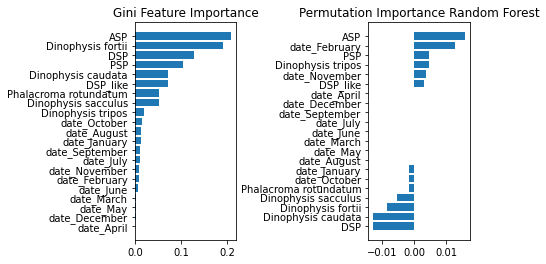

In [28]:
# Feature importance of model (RandomForest) with three methods!
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=1.3)

# Split data and fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None)
rf.fit(X_train, y_train)

# Get feature importance with Gini importance (mean decreased impurity)
# print(rf.feature_importances_)
gini_sorted_idx = rf.feature_importances_.argsort()
x1 = X.columns[gini_sorted_idx]
y1 = rf.feature_importances_[gini_sorted_idx]
ax1.barh(x1, y1)
ax1.set_title("Gini Feature Importance")

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(rf, X_test, y_test)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance Random Forest")

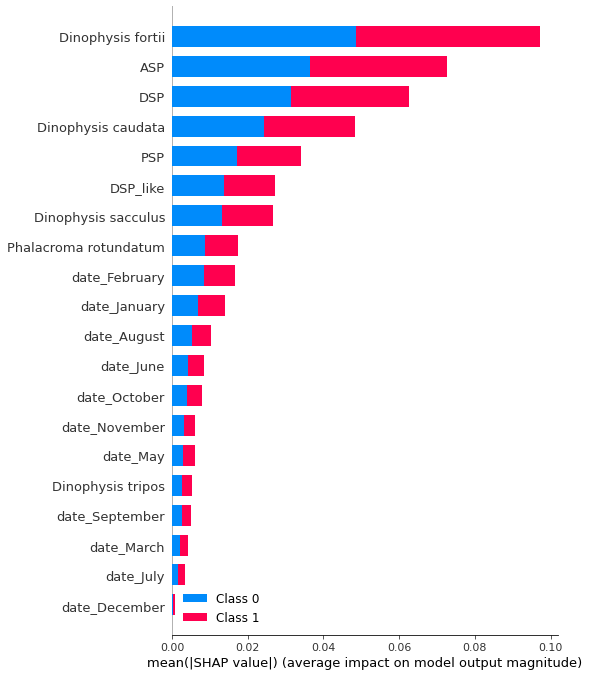

In [29]:
# Get feature importance with SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
RF_shap = shap.summary_plot(shap_values, X_test, plot_type="bar")

### Neural Network Model

#### Model Evaluation (MLP)

In [30]:
# Model evaluation with the pipeline of SMOTE oversampling and undersampling on the training dataset only (within each cross-validation fold)!
# Evaluate k (SMOTE) parameter. 
from sklearn.neural_network import MLPClassifier

# Cross-validation of model with ROC AUC with SMOTE pipeline  
# define pipeline
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(20,10), max_iter=3000, random_state=1)
over = SMOTE(sampling_strategy=0.5, k_neighbors=k)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('over', over), ('under', under), ('clf', clf)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

# Find best performing k-value for SMOTE
k_values = list(range(1,11))
MLP_auc_best_k = (_, 0)
for k in k_values:
    # evaluate pipeline
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))
    if score > MLP_auc_best_k[1]:
        MLP_auc_best_k = (k, score)

print(f">>Best k: k={MLP_auc_best_k[0]} with Mean ROC AUC on resampled dataset: {round(MLP_auc_best_k[1], 2)}")  

# Cross-validation of model with ROC AUC without SMOTE pipeline  
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
MLP_auc_score = mean(scores)
print(f">>Mean ROC AUC on unsampled dataset: {round(MLP_auc_score, 2)}\n")

# Cross-validation of model with Recall with SMOTE pipeline
# Find best performing k-value for SMOTE
MLP_recall_best_k = (_, 0)
for k in k_values:
    # evaluate pipeline
    scores = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean Recall: %.3f' % (k, score))
    if score > MLP_recall_best_k[1]:
        MLP_recall_best_k = (k, score)

print(f">>Best k: k={MLP_recall_best_k[0]} with Mean Recall on unsampled dataset: {round(MLP_recall_best_k[1], 2)}")  

# Cross-validation of model with Recall without SMOTE pipeline  
scores = cross_val_score(clf, X, y, scoring='recall', cv=cv, n_jobs=-1)
MLP_recall_score = mean(scores)
print(f">>Mean Recall on unsampled dataset: {round(MLP_recall_score, 2)}")

> k=1, Mean ROC AUC: 0.674
> k=2, Mean ROC AUC: 0.652
> k=3, Mean ROC AUC: 0.634
> k=4, Mean ROC AUC: 0.657
> k=5, Mean ROC AUC: 0.669
> k=6, Mean ROC AUC: 0.645
> k=7, Mean ROC AUC: 0.679
> k=8, Mean ROC AUC: 0.666
> k=9, Mean ROC AUC: 0.651
> k=10, Mean ROC AUC: 0.654
>>Best k: k=7 with Mean ROC AUC on resampled dataset: 0.68
>>Mean ROC AUC on unsampled dataset: 0.62

> k=1, Mean Recall: 0.375
> k=2, Mean Recall: 0.421
> k=3, Mean Recall: 0.403
> k=4, Mean Recall: 0.375
> k=5, Mean Recall: 0.437
> k=6, Mean Recall: 0.392
> k=7, Mean Recall: 0.400
> k=8, Mean Recall: 0.382
> k=9, Mean Recall: 0.357
> k=10, Mean Recall: 0.389
>>Best k: k=5 with Mean Recall on unsampled dataset: 0.44
>>Mean Recall on unsampled dataset: 0.32


In [31]:
# GRid search
from sklearn.model_selection import GridSearchCV

NN = MLPClassifier(solver='lbfgs', max_iter=3000)
parameters = {"hidden_layer_sizes": [(3,), (3, 3), (3, 3, 3)]}
gs = GridSearchCV(NN, parameters, scoring="roc_auc", cv=3) # "recall"
gs.fit(X_res, y_res)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=3000, solver='lbfgs'),
             param_grid={'hidden_layer_sizes': [(3,), (3, 3), (3, 3, 3)]},
             scoring='roc_auc')

In [32]:
gs.cv_results_

{'mean_fit_time': array([0.42902978, 0.44627388, 0.38930146]),
 'std_fit_time': array([0.05070847, 0.40747666, 0.25714919]),
 'mean_score_time': array([0.00237497, 0.00249243, 0.002189  ]),
 'std_score_time': array([8.02564141e-05, 3.64852152e-04, 5.11426223e-05]),
 'param_hidden_layer_sizes': masked_array(data=[(3,), (3, 3), (3, 3, 3)],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'hidden_layer_sizes': (3,)},
  {'hidden_layer_sizes': (3, 3)},
  {'hidden_layer_sizes': (3, 3, 3)}],
 'split0_test_score': array([0.82553091, 0.83723454, 0.82895234]),
 'split1_test_score': array([0.8904321 , 0.87402659, 0.87659069]),
 'split2_test_score': array([0.8542735 , 0.85674264, 0.74228395]),
 'mean_test_score': array([0.8567455 , 0.85600126, 0.81594233]),
 'std_test_score': array([0.02655339, 0.01502944, 0.05559689]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

In [33]:
gs.cv_results_

{'mean_fit_time': array([0.42902978, 0.44627388, 0.38930146]),
 'std_fit_time': array([0.05070847, 0.40747666, 0.25714919]),
 'mean_score_time': array([0.00237497, 0.00249243, 0.002189  ]),
 'std_score_time': array([8.02564141e-05, 3.64852152e-04, 5.11426223e-05]),
 'param_hidden_layer_sizes': masked_array(data=[(3,), (3, 3), (3, 3, 3)],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'hidden_layer_sizes': (3,)},
  {'hidden_layer_sizes': (3, 3)},
  {'hidden_layer_sizes': (3, 3, 3)}],
 'split0_test_score': array([0.82553091, 0.83723454, 0.82895234]),
 'split1_test_score': array([0.8904321 , 0.87402659, 0.87659069]),
 'split2_test_score': array([0.8542735 , 0.85674264, 0.74228395]),
 'mean_test_score': array([0.8567455 , 0.85600126, 0.81594233]),
 'std_test_score': array([0.02655339, 0.01502944, 0.05559689]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

#### Feature Importance (MLP)

Text(0.5, 1.0, 'Permutation Importance MLP')

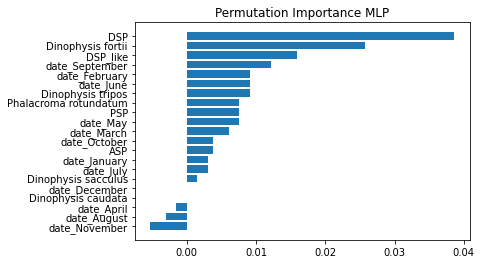

In [34]:
# Feature importance of model (RandomForest) with three methods (no cross-validation!)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt
fig, (ax2) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=1.3)

# Split data and fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
MLP = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(20,10), max_iter=3000, random_state=1)
MLP.fit(X_train, y_train)

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(MLP, X_test, y_test)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance MLP")

In [ ]:
# explain the model's predictions using SHAP
import shap
# explainer = shap.KernelExplainer(clf.predict_proba, X_train)
explainer = shap.KernelExplainer(MLP.predict_proba, shap.sample(pd.DataFrame(X_train, columns=X.columns), 100))
shap_values = explainer.shap_values(X_test)

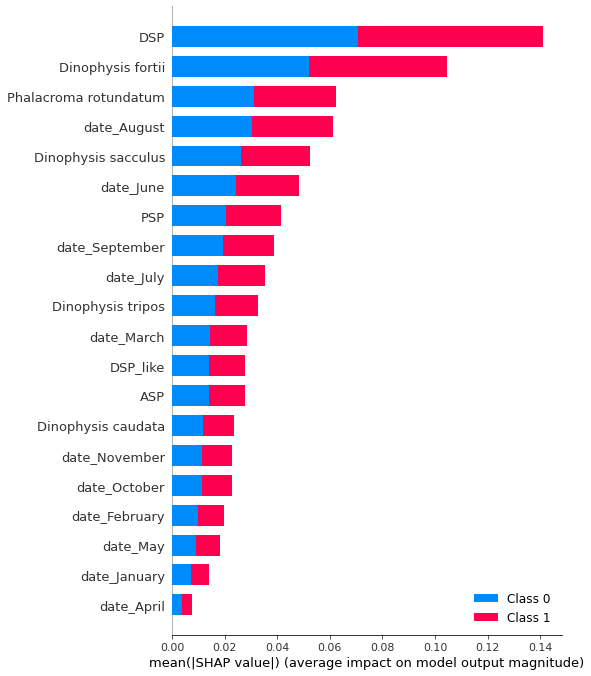

In [36]:
# visualize the first prediction's explanation (Shapley value is the average contribution of features which are predicting in different situation).
shap.summary_plot(shap_values, X_test)

### Conclusion

In [37]:
# Summary table of prediction results
RF_recall = round(RF_recall_best_k[1], 2)
RF_auc = round(RF_auc_best_k[1], 2)
MLP_recall = round(MLP_recall_best_k[1], 2)
MLP_auc = round(MLP_auc_best_k[1], 2)

summary = pd.DataFrame(
    [
        (
            "RF",
            RF_recall_score,
            RF_auc_score,
        ),
        (
            "MLP",
            MLP_recall_score,
            MLP_auc_score,
        ),
        (
            "RF (smote)",
            RF_recall,
            RF_auc,
        ),
        (
            "MLP (smote)",
            MLP_recall,
            MLP_auc,
        ),
        (
            "Decision tree (J48)*",
            0.56,
            0.18,
        ),
    ],
    columns=("Model", "Recall", "ROC AUC"),
).set_index("Model")

print("Table summarising the prediction results of the used classifiers, both with and without SMOTE resampling:\n")
summary.round(2)

Table summarising the prediction results of the used classifiers, both with and without SMOTE resampling:



,Recall,ROC AUC
Model,,
RF,0.24,0.80
MLP,0.32,0.62
RF (smote),0.51,0.80
MLP (smote),0.44,0.68
Decision tree (J48)*,0.56,0.18


As can be seen resampling with SMOTE helped to improve the results substantially, especially when calculating recall. The highest recall and ROC AUC was achieved with Random Forest with the re-sampled data. Both recall and ROC AUC suggest Random Forest as beeing the better classifier for this particular problem. Recall is a crucial metric as it gives indication of what fraction of true positive instances have been predicted. Since the models predict toxins in seashells (food) it is crucial that as few positives as possible are missed.

Due to the use of SMOTE resampling (upsampling and downsampling) in combinaiton with cross-validation it was curcial to do the resampling within each fold to avoid data lekeage and validate on original (unsampled) data. In addition, I have optimised the model with regard to the k-values of SMOTE, all of which brought along some complexity. So for the parameter tuning of Random Forest and MLP various parameter settings have been tried  and the model with best performing settings has been chosen.

The decision tree J48 algorithm was run within Weka on a slightly different dataset (missing values were not removed to use as many instances as possible, cross validation was 10-fold as opposed to 3-fold due to a higher dataset etc.) thus this results are not directly comparable but were provided as a reference to give an indication of the performance of this algorithm. 

As can be seen in the feature importance bar plots above, similar features were on the top despite using two different classification algorithms and two different feature ranking methods. If we consider just the three highest-ranking features of each of the feature ranking methods for both algortihms (RF and MLP) the features that overlap are DSP, DSP_like, ASP, Dinophysis fortii and Dinophysis caudata. These can be shown to the domain experts for validation and interpretation.